# Homework 4

Regression

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [134]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

from utils import decorate
from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot

### Simple regression

An important thing to remember about regression is that it is not symmetric; that is, the regression of A onto B is not the same as the regression of B onto A.

To demonstrate, I'll load data from the BRFSS.

In [135]:
%time brfss = pd.read_hdf('brfss.hdf5', 'brfss')

CPU times: user 9.15 ms, sys: 4.76 ms, total: 13.9 ms
Wall time: 13.2 ms


In [136]:
brfss.head()

,SEX,HTM4,WTKG3,INCOME2,_LLCPWT,_AGEG5YR,_VEGESU1,_HTMG10,AGE
96230,2.0,160.0,60.33,8.0,1398.525290,6.0,2.14,150.0,47.0
244920,2.0,163.0,58.97,5.0,84.057503,13.0,3.14,160.0,89.5
57312,2.0,163.0,72.57,8.0,390.248599,5.0,2.64,160.0,42.0
32573,2.0,165.0,74.84,1.0,11566.705300,3.0,1.46,160.0,32.0
355929,2.0,170.0,108.86,3.0,844.485450,3.0,1.81,160.0,32.0


A few people report many vegetable servings per day.  To simplify the visualization, I'm going to replace values greater than 8 with 8.

In [137]:
rows = brfss['_VEGESU1'] > 8
brfss.loc[rows, '_VEGESU1'] = 8

We can use SciPy to compute servings of vegetables as a function of income class.

In [138]:
from scipy.stats import linregress

subset = brfss.dropna(subset=['INCOME2', '_VEGESU1'])
xs = subset['INCOME2']
ys = subset['_VEGESU1']

res = linregress(xs, ys)
res

LinregressResult(slope=0.07046729822137494, intercept=1.514005486687637, rvalue=0.1280026484687731, pvalue=6.0642347876100535e-273, stderr=0.0019880464492623346)

Increasing income class by 1 is associated with an increase of 0.07 vegetables per day.

So if we hypothesize that people with higher incomes eat more vegetables, this result would not get us too excited.

We can see what the regression looks like by plotting the line of best fit on top of the scatter plot.

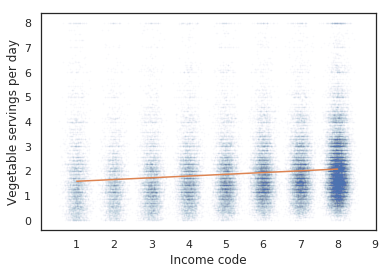

In [139]:
x_jitter = xs + np.random.normal(0, 0.15, len(xs))
plt.plot(x_jitter, ys, 'o', markersize=1, alpha=0.02)

plt.xlabel('Income code')
plt.ylabel('Vegetable servings per day')

fx1 = np.array([xs.min(), xs.max()])
fy1 = res.intercept + res.slope * fx1

plt.plot(fx1, fy1, '-', color='C1');

Now let's do it the other way around, regressing income as a function of vegetable servings.

In [140]:
xs = subset['_VEGESU1']
ys = subset['INCOME2']

res = linregress(xs, ys)
res

LinregressResult(slope=0.23251463343389994, intercept=5.399902962910681, rvalue=0.1280026484687731, pvalue=6.0642347876100535e-273, stderr=0.006559778834540064)

Again, we can plot the line of best fit on top of the scatter plot.

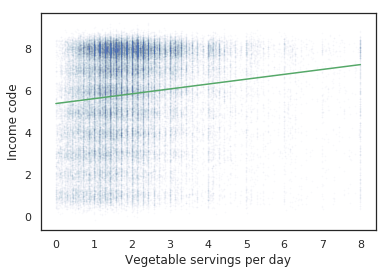

In [141]:
y_jitter = ys + np.random.normal(0, 0.3, len(xs))
plt.plot(xs, y_jitter, 'o', markersize=1, alpha=0.02)

plt.ylabel('Income code')
plt.xlabel('Vegetable servings per day')

fx2 = np.array([xs.min(), xs.max()])
fy2 = res.intercept + res.slope * fx2

plt.plot(fx2, fy2, '-', color='C2');

The slope looks more impressive now.  Each additional serving corresponds to 0.24 income codes, and each income code is several thousand dollars.  So a result that seemed unimpressive in one direction seems more intruiging in the other direction.


But the primary point here is that regression is not symmetric.  To see it more clearly, I'll plot both regression lines on top of the scatter plot.

The green line is income as a function of vegetables; the orange line is vegetables as a function of income.


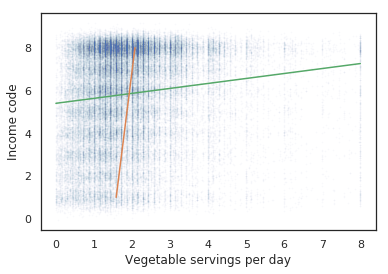

In [142]:
y_jitter = ys + np.random.normal(0, 0.3, len(xs))
plt.plot(xs, y_jitter, 'o', markersize=1, alpha=0.02)

plt.ylabel('Income code')
plt.xlabel('Vegetable servings per day')

fx2 = np.array([xs.min(), xs.max()])
fy2 = res.intercept + res.slope * fx2

plt.plot(fx2, fy2, '-', color='C2')
plt.plot(fy1, fx1, '-', color='C1');

And here's the same thing the other way around.

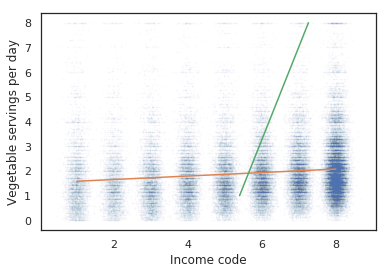

In [143]:
xs = subset['INCOME2']
ys = subset['_VEGESU1']

res = linregress(xs, ys)
res

x_jitter = xs + np.random.normal(0, 0.15, len(xs))
plt.plot(x_jitter, ys, 'o', markersize=1, alpha=0.02)

plt.xlabel('Income code')
plt.ylabel('Vegetable servings per day')

fx1 = np.array([xs.min(), xs.max()])
fy1 = res.intercept + res.slope * fx1

plt.plot(fx1, fy1, '-', color='C1')
plt.plot(fy2, fx1, '-', color='C2');

### StatsModels

So far we have used `scipy.linregress` to run simple regression.  Sadly, that function doesn't do multiple regression, so we have to switch to a new library, StatsModels.

Here's the same example from the previous section, using StatsModels.

In [144]:
import statsmodels.formula.api as smf

model = smf.ols('INCOME2 ~ _VEGESU1', data=brfss)
model

The result is an `OLS` object, which we have to `fit`:

In [145]:
results = model.fit()
results

`results` contains a lot of information about the regression, which we can view using `summary`.

In [146]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                INCOME2   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1256.
Date:                Thu, 28 Mar 2019   Prob (F-statistic):          6.06e-273
Time:                        22:24:49   Log-Likelihood:            -1.6621e+05
No. Observations:               75426   AIC:                         3.324e+05
Df Residuals:                   75424   BIC:                         3.324e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3999      0.015    361.346      0.000       5.371       5.429
_VEGESU1       0.2325      0.007     35.445      0.000       0.220       0.245
==============================================================================
Omnibus:                     7792.716   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8127.444
Skew:                          -0.752   Prob(JB):                         0.00
Kurtosis:                       2.430   Cond. No.                         4.88
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

One of the parts we're interested in is `params`, which is a Pandas Series containing the estimated parameters.

In [147]:
results.params

Intercept    5.399903
_VEGESU1     0.232515
dtype: float64

And `rsquared` contains the coefficient of determination, $R^2$, which is pretty small in this case.

In [148]:
results.rsquared

0.016384678015021414

We can confirm that $R^2 = \rho^2$:

In [149]:
np.sqrt(results.rsquared)

0.12800264846877746

In [150]:
columns = ['INCOME2', '_VEGESU1']
brfss[columns].corr()

,INCOME2,_VEGESU1
INCOME2,1.000000,0.128003
_VEGESU1,0.128003,1.000000


**Exercise:** Run this regression in the other direction and confirm that you get the same estimated slope we got from `linregress`.  Also confirm that $R^2$ is the same in either direction (which we know because correlation is the same in either direction).

In [151]:
model = smf.ols('_VEGESU1 ~ INCOME2', data=brfss)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               _VEGESU1   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1256.
Date:                Thu, 28 Mar 2019   Prob (F-statistic):          6.06e-273
Time:                        22:24:49   Log-Likelihood:            -1.2119e+05
No. Observations:               75426   AIC:                         2.424e+05
Df Residuals:                   75424   BIC:                         2.424e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5140      0.012    121.822      0.000       1.490       1.538
INCOME2        0.0705      0.002     35.445      0.000       0.067       0.074
==============================================================================
Omnibus:                    27267.115   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           115258.690
Skew:                           1.756   Prob(JB):                         0.00
Kurtosis:                       7.933   Cond. No.                         18.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The slope of vegetable servings vs income for the linear regression model was 0.070467, which is the same as the slope of `INCOME2` for the model.

In [152]:
results.params

Intercept    1.514005
INCOME2      0.070467
dtype: float64

The R squared value is the same as the previous model.

In [153]:
results.rsquared

0.01638467801502086

### Multiple regression

For experiments with multiple regression, let's load the GSS data again.

In [154]:
%time gss = pd.read_hdf('gss.hdf5', 'gss')
gss.shape

CPU times: user 26.8 ms, sys: 96.7 ms, total: 123 ms
Wall time: 49.1 ms


(62466, 101)

In [155]:
gss.head()

,year,id_,agewed,divorce,sibs,childs,age,educ,paeduc,maeduc,...,memchurh,realinc,cohort,marcohrt,ballot,wtssall,adults,compuse,databank,wtssnr
0,1972,167,0,0,2,0,26.0,18.0,12,12,...,0,13537.0,1946.0,0,0,0.8893,2.0,0,0,1.0
1,1972,1256,30,2,0,1,38.0,12.0,97,99,...,0,18951.0,1934.0,1964,0,0.4446,1.0,0,0,1.0
2,1972,415,0,0,7,0,57.0,12.0,7,7,...,0,30458.0,1915.0,0,0,1.3339,3.0,0,0,1.0
3,1972,234,18,1,6,3,61.0,14.0,8,5,...,0,37226.0,1911.0,1929,0,0.8893,2.0,0,0,1.0
4,1972,554,22,2,3,3,59.0,12.0,6,11,...,0,30458.0,1913.0,1935,0,0.8893,2.0,0,0,1.0


In [156]:
gss.describe()

,year,id_,agewed,divorce,sibs,childs,age,educ,paeduc,maeduc,...,memchurh,realinc,cohort,marcohrt,ballot,wtssall,adults,compuse,databank,wtssnr
count,62466.000000,62466.000000,62466.000000,62466.000000,62466.000000,62466.000000,62281.000000,62304.000000,62466.000000,62466.000000,...,62466.000000,55499.000000,62282.000000,62466.000000,62466.000000,62466.000000,62403.000000,62466.000000,62466.000000,62466.000000
mean,1994.072359,1141.800211,9.615247,1.221160,4.005699,1.998687,44.648320,12.831311,35.081772,24.966254,...,0.570807,34702.430164,1949.429996,827.367960,1.348029,1.213340,2.250228,0.255531,0.136522,1.097119
std,12.937941,836.093963,12.340079,1.028511,5.601574,1.854561,17.072244,3.117027,39.146742,32.228130,...,0.947610,30665.659411,20.734302,1125.171461,1.219954,0.585544,0.936869,0.586423,0.687817,0.471973
min,1972.000000,1.000000,0.000000,0.000000,-1.000000,0.000000,18.000000,0.000000,0.000000,0.000000,...,0.000000,234.000000,1883.000000,0.000000,0.000000,0.411898,1.000000,0.000000,0.000000,0.293074
25%,1984.000000,487.000000,0.000000,0.000000,2.000000,0.000000,30.000000,12.000000,9.000000,9.000000,...,0.000000,13750.000000,1935.000000,0.000000,0.000000,0.918400,2.000000,0.000000,0.000000,1.000000
50%,1994.000000,1012.000000,0.000000,2.000000,3.000000,2.000000,43.000000,12.000000,12.000000,12.000000,...,0.000000,26015.000000,1951.000000,0.000000,1.000000,1.062100,2.000000,0.000000,0.000000,1.000000
75%,2006.000000,1546.000000,20.000000,2.000000,5.000000,3.000000,57.000000,15.000000,97.000000,16.000000,...,1.000000,43426.000000,1964.000000,1953.000000,2.000000,1.515500,3.000000,0.000000,0.000000,1.000000
max,2016.000000,4510.000000,99.000000,9.000000,99.000000,9.000000,89.000000,20.000000,99.000000,99.000000,...,9.000000,162607.000000,1998.000000,9999.000000,4.000000,8.739876,8.000000,9.000000,9.000000,11.068476


Let's explore the relationship between income and education, starting with simple regression:

In [157]:
model = smf.ols('realinc ~ educ', data=gss)
model

In [158]:
results = model.fit()
results.params

Intercept   -11539.147837
educ          3586.523659
dtype: float64

It looks like people with more education have higher incomes, about $3586 per additional year of education.

Now that we are using StatsModels, it is easy to add explanatory variables.  For example, we can add `age` to the model like this.

In [159]:
model = smf.ols('realinc ~ educ + age', data=gss)
results = model.fit()
results.params

Intercept   -16117.275684
educ          3655.166921
age             83.731804
dtype: float64

It looks like the effect of `age` is small, and adding it to the model has only a small effect on the estimated parameter for education.

But it's possible we are getting fooled by a nonlinear relationship.  To see what the age effect looks like, I'll group by age and plot the mean income in each age group.

In [160]:
grouped = gss.groupby('age')
grouped

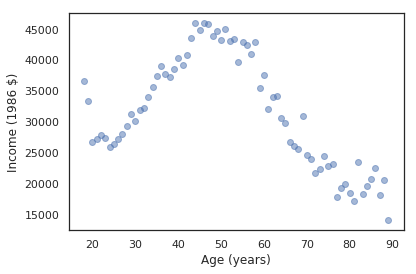

In [161]:
mean_income_by_age = grouped['realinc'].mean()

plt.plot(mean_income_by_age, 'o', alpha=0.5)
plt.xlabel('Age (years)')
plt.ylabel('Income (1986 $)');

Yeah, that looks like a nonlinear effect.

We can model it by adding a quadratic term to the model.

In [162]:
gss['age2'] = gss['age']**2

In [163]:
model = smf.ols('realinc ~ educ + age + age2', data=gss)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                realinc   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     3533.
Date:                Thu, 28 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:24:51   Log-Likelihood:            -6.4543e+05
No. Observations:               55345   AIC:                         1.291e+06
Df Residuals:                   55341   BIC:                         1.291e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.806e+04    985.324    -48.775      0.000      -5e+04   -4.61e+04
educ        3442.4472     39.392     87.389      0.000    3365.238    3519.656
age         1748.2326     39.416     44.353      0.000    1670.976    1825.489
age2         -17.4376      0.406    -42.965      0.000     -18.233     -16.642
==============================================================================
Omnibus:                    17634.223   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51941.449
Skew:                           1.684   Prob(JB):                         0.00
Kurtosis:                       6.344   Cond. No.                     2.27e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now the coefficient associated with `age` is substantially larger.  And the coefficient of the quadratic term is negative, which is  consistent with the observation that the relationship has downward curvature.

**Exercise:** To see what the relationship between income and education looks like, group the dataset by `educ` and plot mean income at each education level.

Text(0, 0.5, 'Income (1986 $)')

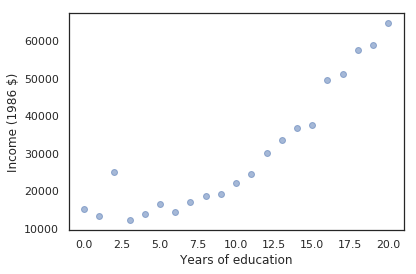

In [164]:
grouped_educ = gss.groupby('educ')
mean_income_by_educ = grouped_educ['realinc'].mean()

plt.plot(mean_income_by_educ, 'o', alpha=0.5)
plt.xlabel('Years of education')
plt.ylabel('Income (1986 $)')

**Exercise:** Maybe the relationship with education is nonlinear, too.  Add a quadratic term for `educ` to the model and summarize the results.

In [165]:
gss['educ2'] = gss['educ']**2

In [166]:
model = smf.ols('realinc ~ educ + educ2 + age + age2', data=gss)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                realinc   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     2792.
Date:                Thu, 28 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:24:51   Log-Likelihood:            -6.4520e+05
No. Observations:               55345   AIC:                         1.290e+06
Df Residuals:                   55340   BIC:                         1.290e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.324e+04   1501.499    -15.479      0.000   -2.62e+04   -2.03e+04
educ        -528.3094    186.045     -2.840      0.005    -892.958    -163.661
educ2        159.9667      7.327     21.834      0.000     145.607     174.327
age         1696.7171     39.319     43.153      0.000    1619.652    1773.782
age2         -17.1970      0.404    -42.538      0.000     -17.989     -16.405
==============================================================================
Omnibus:                    17422.378   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51721.770
Skew:                           1.657   Prob(JB):                         0.00
Kurtosis:                       6.382   Cond. No.                     3.50e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Making predictions

The parameters of a non-linear model can be hard to interpret, but maybe we don't have to.  Sometimes it is easier to judge a model by its predictions rather than its parameters.

The results object provides a `predict` method that takes a `DataFrame` and uses the model to generate a prediction for each row.  Here's how we can create the `DataFrame`:

In [167]:
df = pd.DataFrame()
df['age'] = np.linspace(18, 85)
df['age2'] = df['age']**2

`age` contains equally-spaced points from 18 to 85, and `age2` contains those values squared.

Now we can set `educ` to 12 years of education and generate predictions:

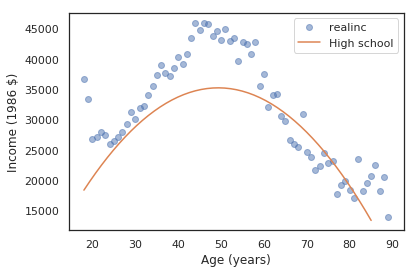

In [168]:
plt.plot(mean_income_by_age, 'o', alpha=0.5)

df['educ'] = 12
df['educ2'] = df['educ']**2
pred12 = results.predict(df)
plt.plot(df['age'], pred12, label='High school')

plt.xlabel('Age (years)')
plt.ylabel('Income (1986 $)')
plt.legend();

This plot shows the structure of the model, which is a parabola.  We also plot the data as an average in each age group.

**Exercise:**  Generate the same plot, but show predictions for three levels of education: 12, 14, and 16 years.

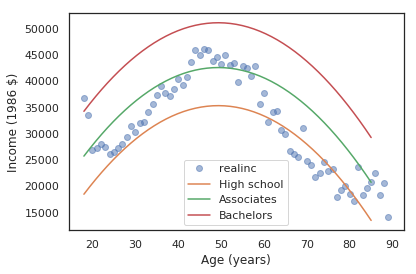

In [169]:
plt.plot(mean_income_by_age, 'o', alpha=0.5)

plt.plot(df['age'], pred12, label='High school')

df = pd.DataFrame()
df['age'] = np.linspace(18, 85)
df['age2'] = df['age']**2

df['educ'] = 14
df['educ2'] = df['educ']**2
pred14 = results.predict(df)
plt.plot(df['age'], pred14, label='Associates')

df = pd.DataFrame()
df['age'] = np.linspace(18, 85)
df['age2'] = df['age']**2

df['educ'] = 16
df['educ2'] = df['educ']**2
pred16 = results.predict(df)
plt.plot(df['age'], pred16, label='Bachelors')

plt.xlabel('Age (years)')
plt.ylabel('Income (1986 $)')
plt.legend();

### Adding categorical variables

In a formula string, we can use `C()` to indicate that a variable should be treated as categorical.  For example, the following model contains `sex` as a categorical variable.

In [170]:
formula = 'realinc ~ educ + educ2 + age + age2 + C(sex)'
results = smf.ols(formula, data=gss).fit()
results.params

Intercept     -22369.453641
C(sex)[T.2]    -4156.113865
educ            -310.247419
educ2            150.514091
age             1703.047502
age2             -17.238711
dtype: float64

The estimated parameter indicates that `sex=2`, which indicates women, is associated with about \$4150 lower income, after controlling for age and education.

**Exercise**: Use `groupby` to group respondents by `educ`, then plot mean `realinc` for each education level.

In [171]:
grouped_educ = gss.groupby('educ')
mean_realinc_by_educ = grouped_educ['realinc'].mean()

Text(0, 0.5, 'Income (1986 $)')

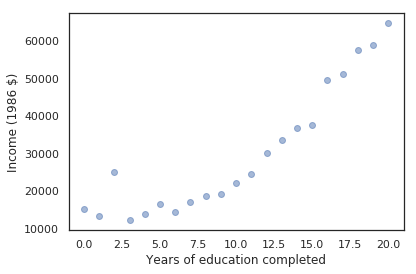

In [172]:
plt.plot(mean_realinc_by_educ, 'o', alpha=0.5)
plt.xlabel('Years of education completed')
plt.ylabel('Income (1986 $)')

**Exercise:** Make a `DataFrame` with a range of values for `educ` and constant `age=30`.  Compute `age2` and `educ2` accordingly.

Use this `DataFrame` to generate predictions for each level of education, holding age constant.  Generate and plot separate predictions for men and women.

Also plot the data for comparison.

In [173]:
df_men = pd.DataFrame()
df_women = pd.DataFrame()

df_men['educ'] = np.linspace(0, 20)
df_men['educ2'] = df_men['educ'] ** 2

df_men['age'] = 30
df_men['age2'] = df_men['age'] ** 2

df_men['sex'] = 1

df_women['educ'] = np.linspace(0, 20)
df_women['educ2'] = df_women['educ'] ** 2

df_women['age'] = 30
df_women['age2'] = df_women['age'] ** 2

df_women['sex'] = 2

pred_men = results.predict(df_men)
pred_women = results.predict(df_women)

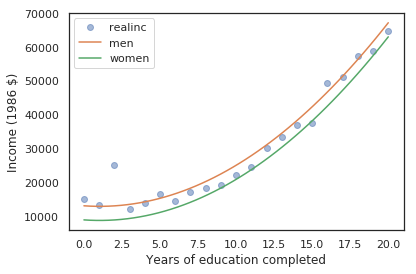

In [174]:
plt.plot(mean_income_by_educ, 'o', alpha=0.5, label='realinc')
plt.plot(df_men['educ'], pred_men, label='men')
plt.plot(df_women['educ'], pred_women, label='women')
plt.xlabel('Years of education completed')
plt.ylabel('Income (1986 $)')
plt.legend()

### Logistic regression

Let's use logistic regression to see what factors are associated with support for gun control.  The variable we'll use is `gunlaw`, which represents the response to this question: "Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?"

Here are the values.

In [175]:
gss['gunlaw'].value_counts()

1    30918
0    21133
2     9632
8      668
9      115
Name: gunlaw, dtype: int64

1 means yes, 2 means no, 0 means the question wasn't asked; 8 and 9 mean the respondent doesn't know or refused to answer.

First I'll replace 0, 8, and 9 with NaN

In [176]:
gss['gunlaw'].replace([0, 8, 9], np.nan, inplace=True)

In order to put `gunlaw` on the left side of a regression, we have to recode it so 0 means no and 1 means yes. 

In [177]:
gss['gunlaw'].replace(2, 0, inplace=True)

Here's what it looks like after recoding.

In [178]:
gss['gunlaw'].value_counts()

1.0    30918
0.0     9632
Name: gunlaw, dtype: int64

Now we can run a logistic regression model

In [179]:
results = smf.logit('gunlaw ~ age + age2 + educ + educ2 + C(sex)', data=gss).fit()

Optimization terminated successfully.
         Current function value: 0.533674
         Iterations 6


Here are the results.

In [180]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 gunlaw   No. Observations:                40355
Model:                          Logit   Df Residuals:                    40349
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Mar 2019   Pseudo R-squ.:                 0.02604
Time:                        22:24:53   Log-Likelihood:                -21536.
converged:                       True   LL-Null:                       -22112.
                                        LLR p-value:                9.637e-247
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.6539      0.150     11.046      0.000       1.360       1.947
C(sex)[T.2]     0.7572      0.024     31.535      0.000       0.710       0.804
age            -0.0188      0.004     -4.915      0.000      -0.026      -0.011
age2            0.0002   3.95e-05      4.791      0.000       0.000       0.000
educ           -0.1244      0.019     -6.500      0.000      -0.162      -0.087
educ2           0.0067      0.001      8.649      0.000       0.005       0.008
===============================================================================
"""

Here are the parameters.  The coefficient of `sex=2` is positive, which indicates that women are more likely to support gun control, at least for this question.

In [181]:
results.params

Intercept      1.653862
C(sex)[T.2]    0.757249
age           -0.018849
age2           0.000189
educ          -0.124373
educ2          0.006653
dtype: float64

The other parameters are not easy to interpret, but again we can use the regression results to generate predictions, which makes it possible to visualize the model.

I'll make a `DataFrame` with a range of ages and a fixed level of education, and generate predictions for men and women.

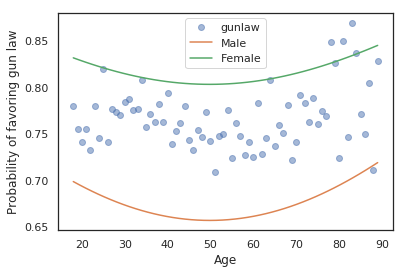

In [191]:
grouped = gss.groupby('age')
favor_by_age = grouped['gunlaw'].mean()
plt.plot(favor_by_age, 'o', alpha=0.5)

df = pd.DataFrame()
df['age'] = np.linspace(18, 89)
df['educ'] = 12

df['age2'] = df['age']**2
df['educ2'] = df['educ']**2

df['sex'] = 1
pred = results.predict(df)
plt.plot(df['age'], pred, label='Male')

df['sex'] = 2
pred = results.predict(df)
plt.plot(df['age'], pred, label='Female')

plt.xlabel('Age')
plt.ylabel('Probability of favoring gun law')
plt.legend();

Over the range of ages, women are more likely to support gun control than men, by about 15 percentage points.

**Exercise:** Generate a similar plot as a function of education, with constant `age=40`.

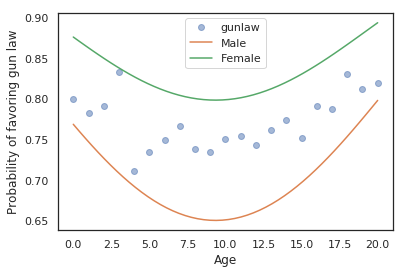

In [202]:
grouped = gss.groupby('educ')
favor_by_educ = grouped['gunlaw'].mean()
plt.plot(favor_by_educ, 'o', alpha=0.5)

df['educ'] = np.linspace(0, 20)
df['educ2'] = df['educ']**2

df['age'] = 40
df['age2'] = 40**2

df['sex'] = 1
pred = results.predict(df)
plt.plot(df['educ'], pred, label='Male')

df['sex'] = 2
pred = results.predict(df)
plt.plot(df['educ'], pred, label='Female')

plt.xlabel('Age')
plt.ylabel('Probability of favoring gun law')
plt.legend();

**Exercise:** Use the variable `grass` to explore support for legalizing marijuana.  This variable record the response to this question: "Do you think the use of marijuana should be made legal or not?"

1. Recode `grass` for use with logistic regression.

2. Run a regression model with age, education, and sex as explanatory variables.

3. Use the model to generate predictions for a range of ages, with education held constant, and plot the predictions for men and women.  Also plot the mean level of support in each age group.

4. Use the model to generate predictions for a range of education levels, with age held constant, and plot the predictions for men and women.  Also plot the mean level of support at each education level.

Note: This last graph might not look like a parabola.  Why not?

In [204]:
gss['grass'].value_counts()

2    25195
0    24398
1    11027
8     1733
9      113
Name: grass, dtype: int64

In [217]:
gss['grass'].replace([0, 8, 9], np.nan, inplace=True)
gss['grass'].replace([2], 0, inplace=True)
gss['grass'].value_counts()

0.0    25195
1.0    11027
Name: grass, dtype: int64

In [223]:
results = smf.logit('grass ~ age + age2 + educ + educ2 + C(sex)', data=gss).fit()
results.params

Optimization terminated successfully.
         Current function value: 0.588510
         Iterations 6


Intercept     -1.685223
C(sex)[T.2]   -0.384611
age           -0.034756
age2           0.000192
educ           0.221860
educ2         -0.004163
dtype: float64

,age,age2,educ,educ2,sex
0,18.000000,324.000000,14,196,2
1,19.367347,375.094127,14,196,2
2,20.734694,429.927530,14,196,2
3,22.102041,488.500208,14,196,2
4,23.469388,550.812162,14,196,2


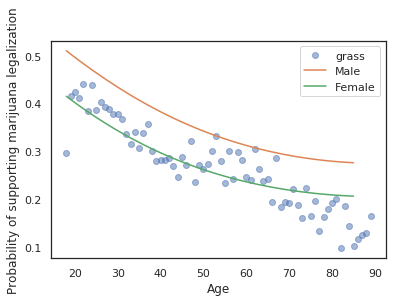

In [225]:
grouped = gss.groupby('age')
favor_by_age = grouped['grass'].mean()
plt.plot(favor_by_age, 'o', alpha=0.5)

df = pd.DataFrame()

df['age'] = np.linspace(18, 85)
df['age2'] = df['age'] ** 2
df['educ'] = 14
df['educ2'] = df['educ'] ** 2

df['sex'] = 1
pred = results.predict(df)

plt.plot(df['age'], pred, label='Male')

df['sex'] = 2
pred = results.predict(df)

plt.plot(df['age'], pred, label='Female')

plt.xlabel('Age')
plt.ylabel('Probability of supporting marijuana legalization')
plt.legend();

df.head()

,educ,educ2,age,age2,sex
0,0.000000,0.000000,30,900,2
1,0.408163,0.166597,30,900,2
2,0.816327,0.666389,30,900,2
3,1.224490,1.499375,30,900,2
4,1.632653,2.665556,30,900,2


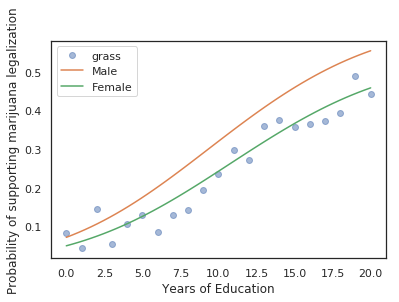

In [227]:
grouped = gss.groupby('educ')
favor_by_educ = grouped['grass'].mean()
plt.plot(favor_by_educ, 'o', alpha=0.5)

df = pd.DataFrame()

df['educ'] = np.linspace(0, 20)
df['educ2'] = df['educ'] ** 2
df['age'] = 30
df['age2'] = df['age'] ** 2

df['sex'] = 1
pred = results.predict(df)

plt.plot(df['educ'], pred, label='Male')

df['sex'] = 2
pred = results.predict(df)

plt.plot(df['educ'], pred, label='Female')

plt.xlabel('Years of Education')
plt.ylabel('Probability of supporting marijuana legalization')
plt.legend();

df.head()

This last graph may not look like a parabola because the educ2 param is much smaller than the educ term, so the linear term dominates.